In [1]:
import pickle
import warnings

import pandas as pd
import numpy as np
from scipy.stats import norm, uniform
import pymc3 as pm

import seaborn as sb
import matplotlib.pyplot as pl
import arviz as ar
import altair as alt
import cmocean.cm as cmo

In [2]:
def make_lower_triangle(gs):
    for i, j in zip(*np.triu_indices_from(gs.axes, 1)):
        gs.axes[i, j].set_visible(False)
    gs.axes[0,0].set_xlabel(gs.axes[0,0].get_ylabel())
    gs.axes[0,0].set_ylabel('')
    gs.axes[0,0].set_yticks([])

In [3]:
%matplotlib inline
alt.renderers.enable('notebook')
warnings.filterwarnings('ignore',  category=FutureWarning)

In [4]:
df_data = pd.read_pickle('./pickleJar/df_logMxBlues.pkl')

In [5]:
df_data.head().T

,0,1,2,3,4
rrs411_l,-2.48181,-2.69759,-2.57346,-2.74698,-2.85684
rrs443_l,-2.39369,-2.57914,-2.48391,-2.66945,-2.77425
rrs489_l,-2.32961,-2.44558,-2.39021,-2.56902,-2.6778
rrs510_l,-2.29265,-2.38804,-2.36096,-2.5593,-2.70144
rrs555_l,-2.26695,-2.36376,-2.34046,-2.59924,-2.80625
rrs670_l,-3.07818,-3.13471,-3.16042,-3.50443,-3.79611
mxBl_l,-2.29265,-2.38804,-2.36096,-2.5593,-2.6778
mxBlId,rrs510,rrs510,rrs510,rrs510,rrs489
MxBl-Gr,-0.0257098,-0.0242776,-0.0205022,0.0399411,0.128449
mxBlColor,#4eb3d3,#4eb3d3,#4eb3d3,#4eb3d3,#2b8cbe


In [6]:
df_data.insert(df_data.columns.get_loc('mxBlId'), 'mxBlId2',
           df_data.loc[:, ['rrs443_l', 'rrs510_l']].idxmax(axis=1).str.replace('_l', ''))

In [7]:
df_data.insert(df_data.columns.get_loc('MxBl-Gr'), 'MxBl-Gr2',
          df_data.loc[:, ['rrs443_l', 'rrs510_l']].max(axis=1) - df_data.loc[:, 'rrs555_l'])

In [8]:
df_data.head().T

,0,1,2,3,4
rrs411_l,-2.48181,-2.69759,-2.57346,-2.74698,-2.85684
rrs443_l,-2.39369,-2.57914,-2.48391,-2.66945,-2.77425
rrs489_l,-2.32961,-2.44558,-2.39021,-2.56902,-2.6778
rrs510_l,-2.29265,-2.38804,-2.36096,-2.5593,-2.70144
rrs555_l,-2.26695,-2.36376,-2.34046,-2.59924,-2.80625
rrs670_l,-3.07818,-3.13471,-3.16042,-3.50443,-3.79611
mxBl_l,-2.29265,-2.38804,-2.36096,-2.5593,-2.6778
mxBlId2,rrs510,rrs510,rrs510,rrs510,rrs510
mxBlId,rrs510,rrs510,rrs510,rrs510,rrs489
MxBl-Gr2,-0.0257098,-0.0242776,-0.0205022,0.0399411,0.104812


In [9]:
df_data[['MxBl-Gr', 'chl_l']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4459 entries, 0 to 4458
Data columns (total 2 columns):
MxBl-Gr    4453 non-null float64
chl_l      4127 non-null float64
dtypes: float64(2)
memory usage: 104.5 KB


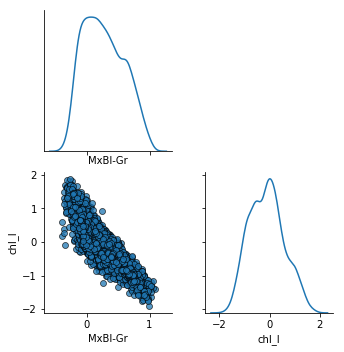

In [10]:
g = sb.PairGrid(df_data.loc[:,['MxBl-Gr', 'chl_l']],
                diag_sharey=False)
g.map_diag(sb.kdeplot, )
g.map_offdiag(sb.scatterplot, alpha=0.75, edgecolor='k');
make_lower_triangle(g)

### Modeling log$_{10}$(chl) distribution


#### Grid approximation

* model using two parameters, a mean $\mu$, and standard deviation, $\sigma$
* create a 2D grid of possible $\mu$ and $\sigma$ 
* define priors for both $\mu$ and $\sigma$
* compute likelihood
* compute posterior 

<u>Note</u>:


$\rightarrow$probabilities are logtransformed for easier posterior computation,
<br>
$\rightarrow$store everything in a pandas DataFrame, "df", for ease of manipulation.

#### Define grid over which probability distribution parameters $\mu$ (mean) and $\sigma$ (std) will be computed

In [11]:
# μ-axis
μ = np.linspace(-2, 2, num=200)
# σ-axis
σ = np.linspace(0, 2, num=200)
df_bayes = pd.DataFrame([[μ_i, σ_i] for σ_i in σ for μ_i in μ],
                    columns=['μ', 'σ']
                    )

#### define prior probability distributions for $\mu$ and $\sigma$

Next I define priors. Other priors will be tested later. 
* $\mu \sim \mathcal{N}(1, 1)$: a gaussian distribution centered at 1, with an sd of 1
* $\sigma \sim \mathcal{U}(0, 2)$: a uniform distribution between 0 and 2

In [ ]:
μ_prior = norm.logpdf(df_bayes.μ, 1, 1)
σ_prior = uniform.logpdf(df_bayes.σ, 0, 2)

### compute multi-dimensional prior probability

In [ ]:
# log prior probability
df_bayes['log_prior_prob'] = μ_prior + σ_prior
# straight prior probability
df_bayes['prior_prob'] = np.exp(df_bayes.log_prior_prob - df_bayes.log_prior_prob.max())

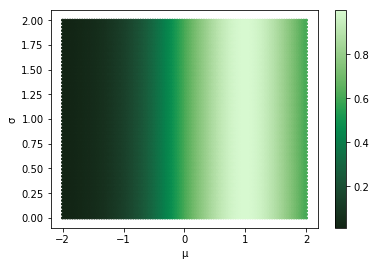

In [13]:
df_bayes.plot.hexbin(x='μ', y='σ', C='prior_prob',
                     cmap=cmo.algae_r, sharex=False);

#### Subsample the data

* show the impact of priors
* computationally more tractable given the grid approach currently used

In [14]:
sample_N = 10
df_data_s = df_data.dropna().sample(n=sample_N)

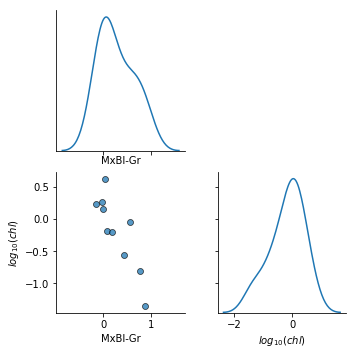

In [49]:
g = sb.PairGrid(df_data_s.loc[:,['MxBl-Gr', 'chl_l']],
                diag_sharey=False)
g.map_diag(sb.kdeplot, )
g.map_offdiag(sb.scatterplot, alpha=0.75, edgecolor='k');
make_lower_triangle(g)
g.axes[1,0].set_ylabel(r'$log_{10}(chl)$');
g.axes[1,1].set_xlabel(r'$log_{10}(chl)$');

#### Compute Log-Likelihood (probability of the data for each $(\mu,\sigma)$ grid pair

In [16]:
df_bayes['LL'] = np.sum(norm.logpdf(df_data_s.chl_l.values.reshape(1, -1),
                                    loc=df_bayes.μ.values.reshape(-1, 1),
                                    scale=df_bayes.σ.values.reshape(-1, 1)
                                   ), axis=1)

#### Compute Posterior

In [17]:
df_bayes['log_post_prob'] = df_bayes.LL + df_bayes.log_prior_prob # compute log-probability
df_bayes['post_prob'] = np.exp(df_bayes.log_post_prob
                               - df_bayes.log_post_prob.max()) # convert to straight prob.

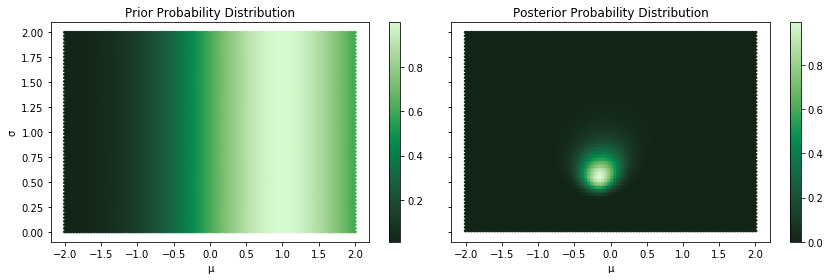

In [45]:
# Plot Multi-Dimensional Prior and Posterior
f, ax = pl.subplots(ncols=2, figsize=(12, 4), sharey=True)
df_bayes.plot.hexbin(x='μ', y='σ', C='prior_prob',
                    cmap=cmo.algae_r, sharex=False, ax=ax[0])
df_bayes.plot.hexbin(x='μ', y='σ', C='post_prob',
                     cmap=cmo.algae_r, sharex=False, ax=ax[1]);
ax[0].set_title('Prior Probability Distribution')
ax[1].set_title('Posterior Probability Distribution')
f.tight_layout()

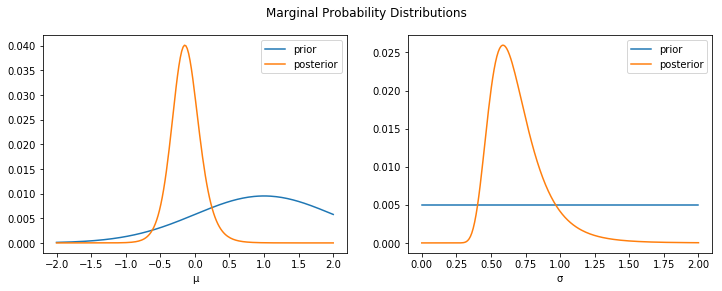

In [44]:
# Compute Marginal Priors and Posteriors for each Parameter
df_μ = df_bayes.groupby(['μ']).sum().drop('σ', axis=1)[['prior_prob',
                                                        'post_prob']].reset_index()
df_σ = df_bayes.groupby(['σ']).sum().drop('μ', axis=1)[['prior_prob',
                                                        'post_prob']].reset_index() 

# Normalize Probability Distributions
df_μ.prior_prob /= df_μ.prior_prob.sum()
df_μ.post_prob /=df_μ.post_prob.sum()
df_σ.prior_prob /= df_σ.prior_prob.sum()
df_σ.post_prob /=df_σ.post_prob.sum()

#Plot Marginal Priors and Posteriors
f, ax = pl.subplots(ncols=2, figsize=(12, 4))
df_μ.plot(x='μ', y='prior_prob', ax=ax[0], label='prior');
df_μ.plot(x='μ', y='post_prob', ax=ax[0], label='posterior')
df_σ.plot(x='σ', y='prior_prob', ax=ax[1], label='prior')
df_σ.plot(x='σ', y='post_prob', ax=ax[1], label='posterior');
f.suptitle('Marginal Probability Distributions');

### Impact of Priors

In [64]:
def compute_bayes_framework(data, priors_dict):
    # build grid:
    μ = np.linspace(-2, 2, num=200)
    σ = np.linspace(0, 2, num=200)
    df_b = pd.DataFrame([[μ_i, σ_i] for σ_i in σ for μ_i in μ],
                    columns=['μ', 'σ']
                    )
    # compute/store distributions
    μ_prior = norm.logpdf(df_b.μ, priors_dict['μ_mean'], priors_dict['μ_sd'])
    σ_prior = uniform.logpdf(df_b.σ, priors_dict['σ_lo'], priors_dict['σ_hi'])
    df_b['log_prior_prob'] = μ_prior + σ_prior 
    df_b['prior_prob'] = np.exp(df_b.log_prior_prob
                                    - df_b.log_prior_prob.max())
    df_b['LL'] = np.sum(norm.logpdf(data.chl_l.values.reshape(1, -1),
                                    loc=df_b.μ.values.reshape(-1, 1),
                                    scale=df_b.σ.values.reshape(-1, 1)
                                   ), axis=1)
    df_b['log_post_prob'] = df_b.LL + df_b.log_prior_prob
    df_b['post_prob'] = np.exp(df_b.log_post_prob
                               - df_b.log_post_prob.max())
    return df_b


def plot_posterior(df_, ax1, ax2):
    df_.plot.hexbin(x='μ', y='σ', C='prior_prob',
                        cmap=cmo.algae_r, sharex=False, ax=ax1)
    df_.plot.hexbin(x='μ', y='σ', C='post_prob',
                         cmap=cmo.algae_r, sharex=False, ax=ax2);
    ax1.set_title('Prior Probability Distribution')
    ax2.set_title('Posterior Probability Distribution')
    

def plot_marginals(df_, ax1, ax2):
    df_μ = df_.groupby(['μ']).sum().drop('σ', axis=1)[['prior_prob',
                                                        'post_prob']].reset_index()
    df_σ = df_.groupby(['σ']).sum().drop('μ', axis=1)[['prior_prob',
                                                            'post_prob']].reset_index() 

    # Normalize Probability Distributions
    df_μ.prior_prob /= df_μ.prior_prob.max()
    df_μ.post_prob /=df_μ.post_prob.max()
    df_σ.prior_prob /= df_σ.prior_prob.max()
    df_σ.post_prob /=df_σ.post_prob.max()

    #Plot Marginal Priors and Posteriors
    df_μ.plot(x='μ', y='prior_prob', ax=ax1, label='prior');
    df_μ.plot(x='μ', y='post_prob', ax=ax1, label='posterior')
    df_σ.plot(x='σ', y='prior_prob', ax=ax2, label='prior')
    df_σ.plot(x='σ', y='post_prob', ax=ax2, label='posterior');

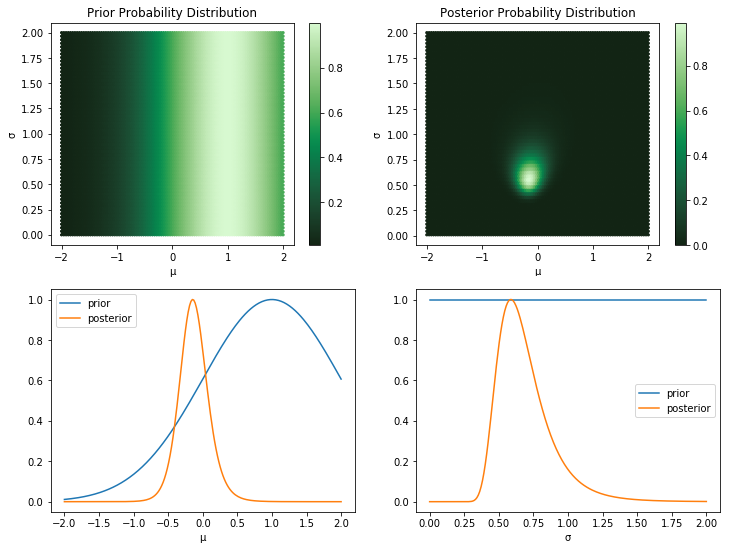

In [65]:
priors=dict(μ_mean=1, μ_sd=1, σ_lo=0, σ_hi=2)
df_1 = compute_bayes_framework(df_data_s, priors_dict=priors)

_ , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 9))
axp = axp.ravel()
plot_posterior(df_1, axp[0], axp[1])
plot_marginals(df_1, axp[2], axp[3])

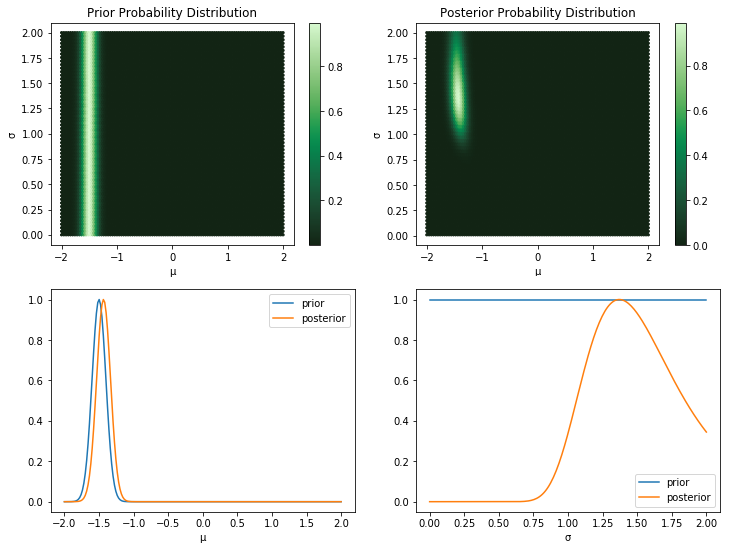

In [66]:
priors=dict(μ_mean=-1.5, μ_sd=.1, σ_lo=0, σ_hi=2)
df_2 = compute_bayes_framework(df_data_s, priors_dict=priors)

_ , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 9))
axp = axp.ravel()
plot_posterior(df_1, axp[0], axp[1])
plot_marginals(df_1, axp[2], axp[3])

### <u>Impact of data set size</u>

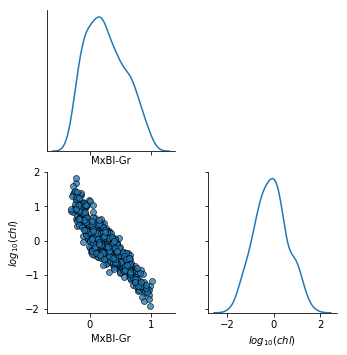

In [68]:
sample_N = 500
df_data_s = df_data.dropna().sample(n=sample_N)
g = sb.PairGrid(df_data_s.loc[:,['MxBl-Gr', 'chl_l']],
                diag_sharey=False)
g.map_diag(sb.kdeplot, )
g.map_offdiag(sb.scatterplot, alpha=0.75, edgecolor='k');
make_lower_triangle(g)
g.axes[1,0].set_ylabel(r'$log_{10}(chl)$');
g.axes[1,1].set_xlabel(r'$log_{10}(chl)$');

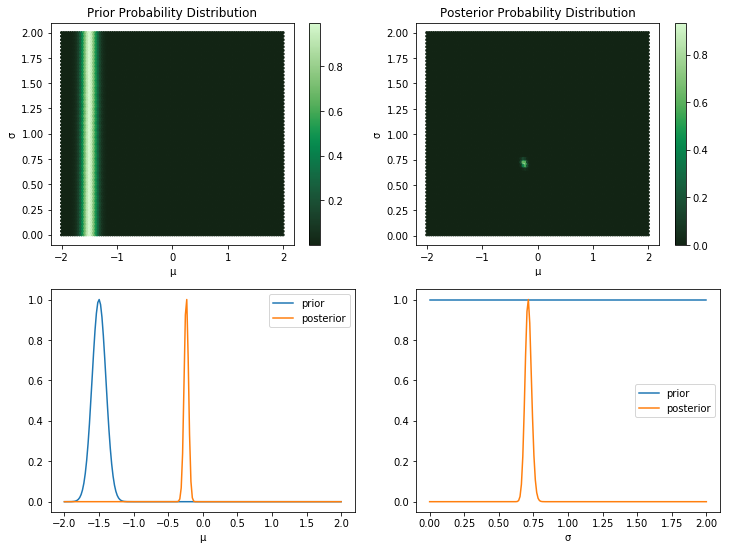

In [71]:
priors=dict(μ_mean=1, μ_sd=1, σ_lo=0, σ_hi=2)
df_3 = compute_bayes_framework(df_data_s, priors_dict=priors)

_ , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 9))
axp = axp.ravel()
plot_posterior(df_1, axp[0], axp[1])
plot_marginals(df_1, axp[2], axp[3])

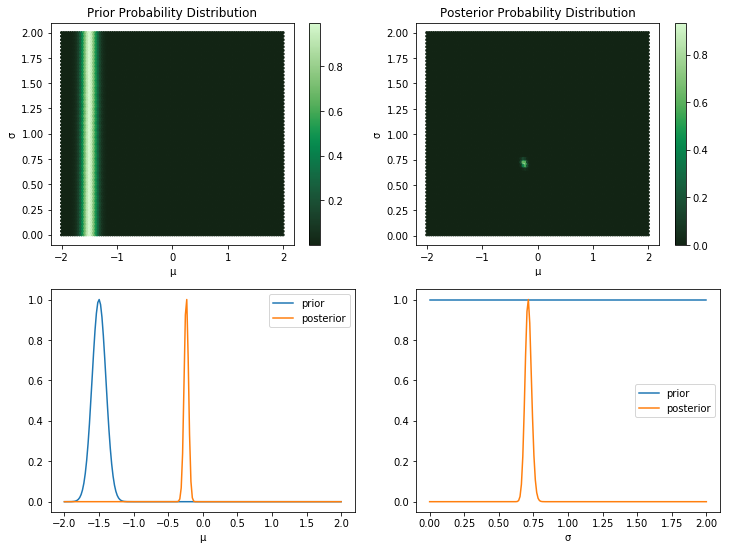

In [72]:
priors=dict(μ_mean=-1.5, μ_sd=.1, σ_lo=0, σ_hi=2)
df_4 = compute_bayes_framework(df_data_s, priors_dict=priors)

_ , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 9))
axp = axp.ravel()
plot_posterior(df_3, axp[0], axp[1])
plot_marginals(df_3, axp[2], axp[3])

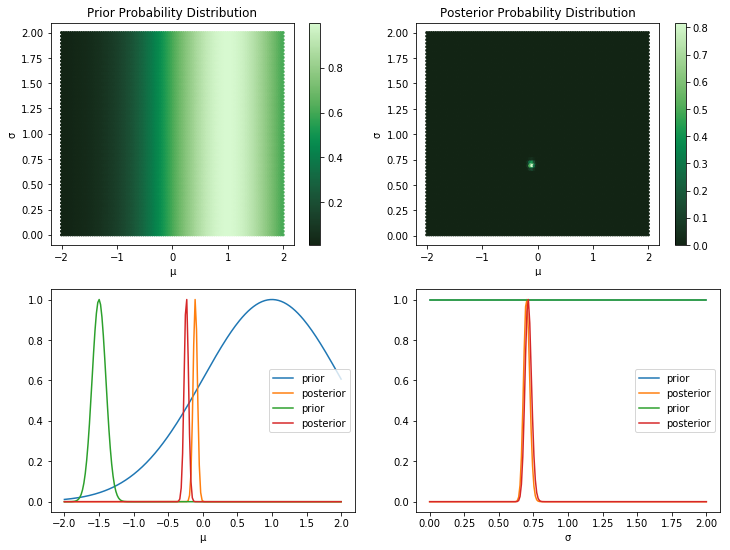

In [74]:
_ , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 9))
axp = axp.ravel()
plot_posterior(df_3, axp[0], axp[1])
plot_marginals(df_3, axp[2], axp[3])
plot_marginals(df_4, axp[2], axp[3])

#### <u>Dealing with computational complexity: Approximating the posterior with MCMC</u>

* Grid approximation:
    * computationally intensive
    * impractical and often intractable at higher dimensions
    
* MCMC allows sampling where it probabilistically matters:
    * propose jump to new location in parameter space
    * compute probability of new location
    * compute ratio $\frac{new probability}{old probability}$
    * jump if ratio greater than one
    * otherwise jump if ratio greater than random number $\in [0, 1]$

In [87]:
# Manual MCMC
# For simplicity we're only going to look at the 
def compute_likelihood(d_data, params):
    log_lkl = np.sum(norm.logpdf(d_data.chl_l.values.reshape(1, -1),
                                 loc=params['μ'], scale=params['σ']
                                ),
                     axis=1)
    lkl = np.exp(log_lkl)
    return lkl

def compute_prior(params, starting_point):
    pass

def mcmc(d_data, params, starting_point, n_samples=1000):
    σ=0.75
    p_μ = np.nan * np.ones(n_samples)
    p_μ[0] = 0.5
    for i in range(1, n_samples):
        new_μ = norm.rvs(loc=p_μ[i-1], scale=0.1, size=1)
        q1 = compute_likelihood(d_data, dict(μ=new_μ, σ=σ))
        q0 = compute_likelihood(d_data, dict(μ=p_μ[i-1], σ=σ))
        ratio = q1/q0
        if ratio > 1:
            # accept proposal
            p_μ[i] = new_μ
        else:
            # evaluate low proba proposal
            if uniform.rvs(size=1, loc=0, scale=1) > ratio:
                # reject proposal
                p_μ[i] = p_μ[i-1]    
            else:
                # accept proposal
                p_μ[i] = new_μ
    return p_μ

In [ ]:
# Probabilistic programming with PyMC3

### <u>Regression: adding a predictor</u>

In [85]:
uniform.rvs(size=1, loc=0, scale=1)

array([0.19864632])

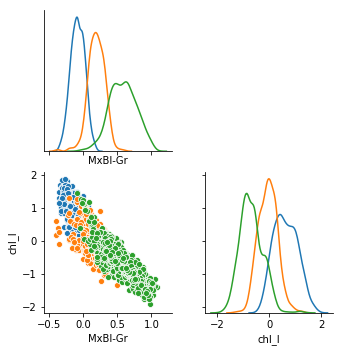

In [119]:
g3 = sb.PairGrid(df_.loc[:, ['MxBl-Gr', 'chl_l', 'mxBlId']],
               hue='mxBlId', diag_sharey=False)
g3.map_diag(sb.kdeplot, )
g3.map_offdiag(sb.scatterplot);
make_lower_triangle(g3)

In [39]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4459 entries, 0 to 4458
Data columns (total 15 columns):
rrs411_l     4293 non-null float64
rrs443_l     4456 non-null float64
rrs489_l     4422 non-null float64
rrs510_l     4207 non-null float64
rrs555_l     4453 non-null float64
rrs670_l     3822 non-null float64
mxBl_l       4459 non-null float64
mxBlId2      4456 non-null object
mxBlId       4459 non-null object
MxBl-Gr2     4450 non-null float64
MxBl-Gr      4453 non-null float64
mxBlColor    4459 non-null object
is_hplc      4127 non-null float64
chl_l        4127 non-null float64
chl          4127 non-null float64
dtypes: float64(12), object(3)
memory usage: 717.4+ KB


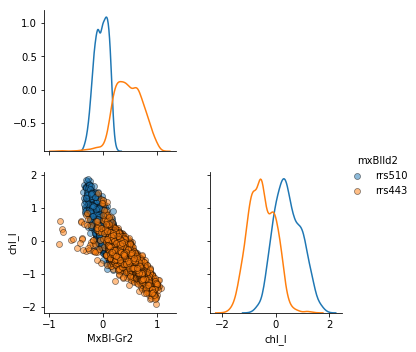

In [91]:
g = sb.PairGrid(df_.loc[:, ['MxBl-Gr2', 'chl_l', 'mxBlId2']],
               hue='mxBlId2', diag_sharey=False)
g.map_diag(sb.kdeplot, )
g.map_offdiag(sb.scatterplot, alpha=0.5, edgecolor='k')
g.add_legend();
make_lower_triangle(g)